<a href="https://colab.research.google.com/github/etmaca5/Biology/blob/main/Casanova_Etienne_hw7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Homework 7: Gene expression, by experiment

#### **Please read the following instructions carefully before you continue.**

This template notebook is for Homework 7, due Thursday, May 25th, 2023.

To use this template, click `File` > `Save a copy in Drive`. You now have your own editable copy to which you can add your code. However, before you make changes, note that we've scaffolded this notebook to help get you started:

- We've already written `import` statements for all the modules you should need. This week, you could feasibly do everything without importing any external modules; do whatever is most helpful for you.
- We provide an introduction that lays out one potential approach for solving the problem, explaining what each logical "chunk" of your code ought to accomplish. You can use this as a starting point for writing your own code.  

Of course, if you'd rather do your own thing, you are not required to follow the path we've laid out, or use the modules we've recommended. However, a few things _are_ required (refer to the [Intro to Colab](https://colab.research.google.com/drive/1fq_HaiuYb1L18uGcoA3eGs6taiUafR-6?usp=sharing) notebook):

- _Literate style._ Dumping everything into a single, monstrous code cell is illegible and unacceptable. Remember to divide your code into reasonable, logical chunks, and to follow up each code cell with a text cell that explains and interprets the results. Try to minimize copy-and-pasting; instead, define functions and use thoughtful iteration to accomplish repetitive tasks.
- _Comments._ That said, writing "literate" code is not an excuse to avoid writing comments :)
- _Problem labels/numbers._ Please use text cells to clearly label where your solution to one problem ends, and the next begins.

Remember that a human is going to read and grade your notebook, so it is in your best interest to help them understand your work clearly. Your finished solution to a given problem should flow coherently from one code cell to the next. (Our "scaffold" helps you do this!)

If you get stuck, remember that [tutorials](https://bi1.caltech.edu/2023/tutorials) are held in-person each week.

---

## Introduction

This special "computational project" set serves as the culmination of all your hard work programming this quarter! You'll draw from many of the image segmentation skills you learned in HW 1, and combine them with the plotting you learned to do for HW 3 and 4. Finally, you'll compare your results with the theoretical predictions you made in HW 6.

Most excitingly, you'll use it all to study a real-world dataset, and recapitulate the analysis done in a real-world paper published just a few years ago. In other words, you are going to get your best taste yet of _real_ biological research.

This time, most of the information to get you started isn't included in this template file; instead, it's in the problem set text itself, as well as in the tutorial recordings and notebooks. Reach out if you have any questions!

In [ ]:
## relevant imports
# the usual suspects
import numpy as np
import matplotlib.lines as mlines
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import seaborn as sns


# working with filenames
import glob

# image processing
import skimage.io
import skimage.exposure
import skimage.measure

# csv work
import pandas as pd

# least-squares regression
import scipy.optimize

## Question 1b

In [ ]:
# first calculate calculate ∆εr using the result in the previous table
import math

N_ns = 4.6 * 10**6

R_value = 260

O1_fc = 2.77 * 10**-3
O2_fc = 1.24 * 10**-2
O3_fc = 4.77 * 10**-1

def calc_delta_E_r(R, fold_change):
  return -1 * math.log(N_ns * (1 - fold_change) / (fold_change * R))

print('O1 ∆εr = ' + str(calc_delta_E_r(R_value, O1_fc)))
print('O2 ∆εr = ' + str(calc_delta_E_r(R_value, O2_fc)))
print('O3 ∆εr = ' + str(calc_delta_E_r(R_value, O3_fc)))



O1 ∆εr = -15.667019345677291
O2 ∆εr = -14.158466515303829
O3 ∆εr = -9.872950203620377


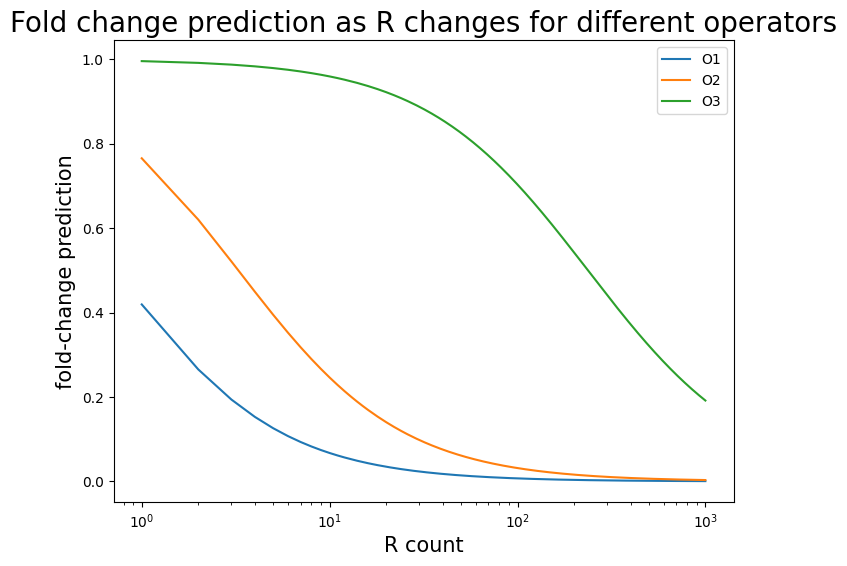

In [ ]:



#function for fold change given


def fold_change(R, E_r):
  return (1 / (1 + (R / N_ns) * math.exp(-1 * E_r)))

O1_E_r = -15.667
O2_E_r = -14.158
O3_E_r = -9.873

single_point_values = [-15.667, -14.158, -9.873]

#as we go from 1 to 1000

R = np.linspace(1, 1000, 1000)

def plot_operator(E_r):
    plt.plot(R, fold_change(R , E_r))


fig, ax = plt.subplots(figsize=(8, 6))
plot_operator(O1_E_r)
plot_operator(O2_E_r)
plot_operator(O3_E_r)
plt.xscale('log')
plt.title("Fold change prediction as R changes for different operators", size = 20);
plt.xlabel('R count', size = 15);
plt.ylabel('fold-change prediction', size = 15);
ax.legend(["O1","O2", "O3"])
plt.show()

## Question 1c



In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


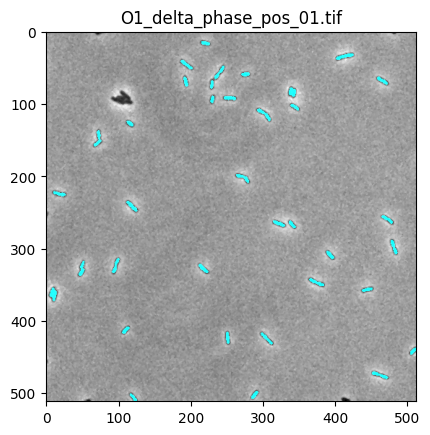

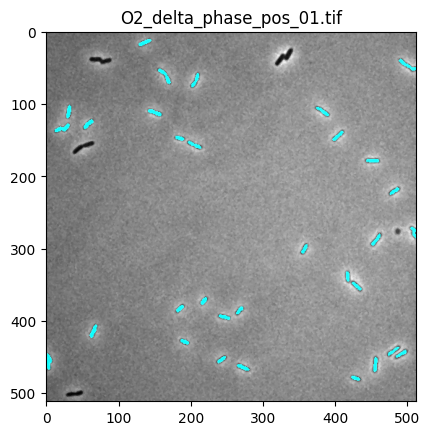

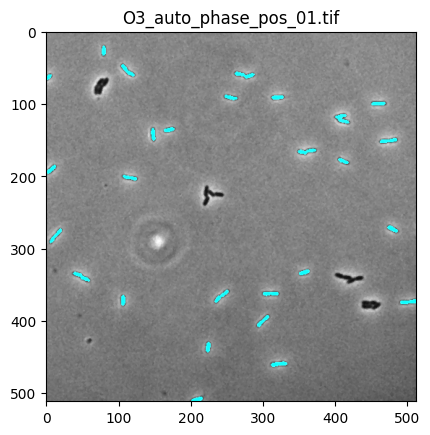

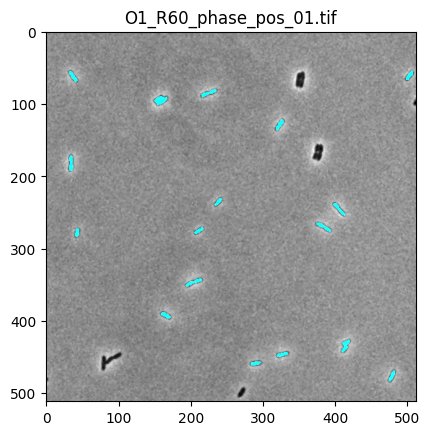

In [ ]:
image_dir = "/content/drive/MyDrive/lacI_titration/"

def segment_im(im_phase, ip_dist=0.160, area_bounds=(1, 4), phase_thresh=0.3, show_mask=False):
  #normalize intensity value of pixels
  im_normed = (im_phase - im_phase.min()) / (im_phase.max() - im_phase.min())
  im_thresh = im_normed < phase_thresh
  #find number of cells now
  im_lab, num_obj = skimage.measure.label(im_thresh, return_num=True)

  #find approved cells
  approved_cells = np.zeros_like(im_thresh)

  for i in range(num_obj - 1):
    # skip first cell as it is the background
    cell = (im_lab == i + 1)
    cell_area_px = np.sum(cell)
    cell_area = cell_area_px * ip_dist**2
    # now test if each cell meets our requirements for a cell
    if (cell_area > area_bounds[0]) and (cell_area < area_bounds[1]):
      approved_cells += cell

  #now check to see if we should
  if(show_mask):
    im_copy = np.copy(im_normed)
    im_copy[approved_cells] = 1.0
    im_rgb = np.dstack((im_normed, im_copy, im_copy))

    fig, ax = plt.subplots()
    ax.imshow(im_rgb)


  return approved_cells


# now to use the function on the given images
examples = ['O1_delta_phase_pos_01.tif', 'O2_delta_phase_pos_01.tif','O3_auto_phase_pos_01.tif','O1_R60_phase_pos_01.tif']

for i in range(len(examples)):
  im = skimage.io.imread(image_dir + examples[i])
  segmentation_mask = segment_im(im, show_mask=True)
  plt.title(examples[i])
  plt.show()

## Question 1d

In [ ]:
def extract_intensities(im_phase, im_fluor):
  im_mask = segment_im(im_phase)
  im_lab, num_cells = skimage.measure.label(im_mask, return_num=True)
  intensity_list = np.zeros(num_cells)
  for i in range(num_cells):
    cell = (im_lab == i + 1)
    tot_intensity = np.sum(cell * im_fluor)
    intensity_list[i] = tot_intensity
  return intensity_list


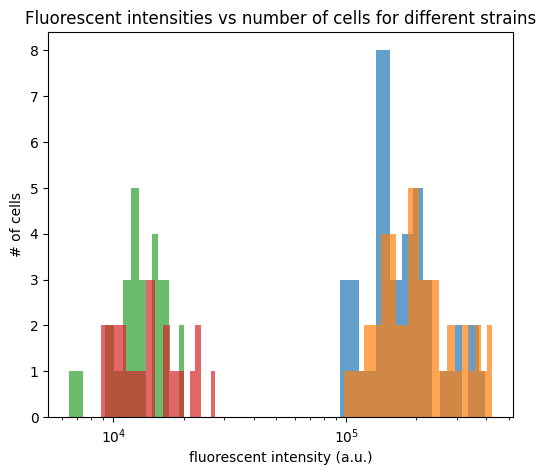

In [ ]:
# now to plot the intensities given the examples from problem 1c.
# sure to plot every single one

fig, ax = plt.subplots(figsize=(6,5))
examples_fluor = ['O1_delta_yfp_pos_01.tif', 'O2_delta_yfp_pos_01.tif', 'O3_auto_yfp_pos_01.tif', 'O1_R60_yfp_pos_01.tif']
for i in range(len(examples)):
  im = skimage.io.imread(image_dir + examples[i])
  im_fluor = skimage.io.imread(image_dir + examples_fluor[i])
  ax.hist(extract_intensities(im,im_fluor), bins=15, alpha = 0.7);
plt.xscale('log')
ax.set_title("Fluorescent intensities vs number of cells for different strains")
ax.set_xlabel('fluorescent intensity (a.u.)')
ax.set_ylabel('# of cells')
plt.show()

## Question 1e

In [ ]:


def strain_totals(op, rep):
    phase_names = np.sort(glob.glob(image_dir + op + '_' + rep + '_phase*.tif'))
    fluor_names = np.sort(glob.glob(image_dir + op + '_' + rep + '_yfp*.tif'))
    strain_intensities = []

    for i in range(len(phase_names)):
        im_phase = skimage.io.imread(phase_names[i])
        im_fluor = skimage.io.imread(fluor_names[i])
        intensities = extract_intensities(im_phase, im_fluor)
        for val in intensities:
            strain_intensities.append(val)

    return strain_intensities

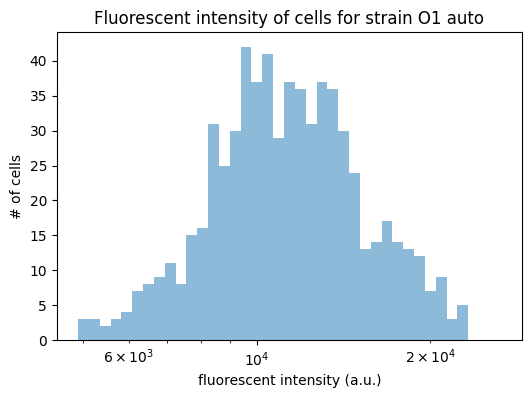

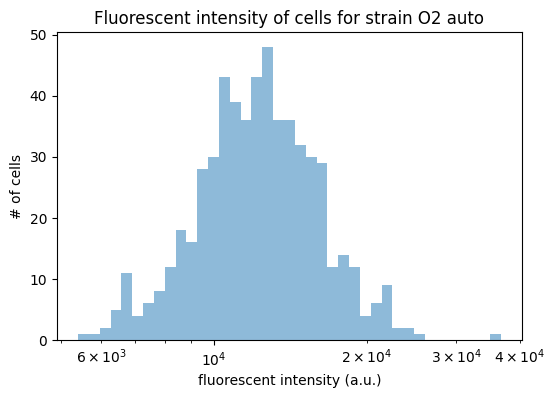

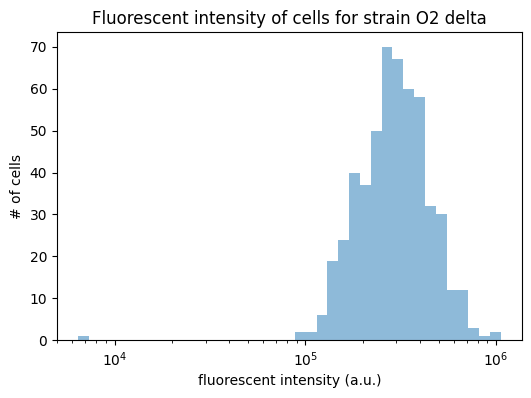

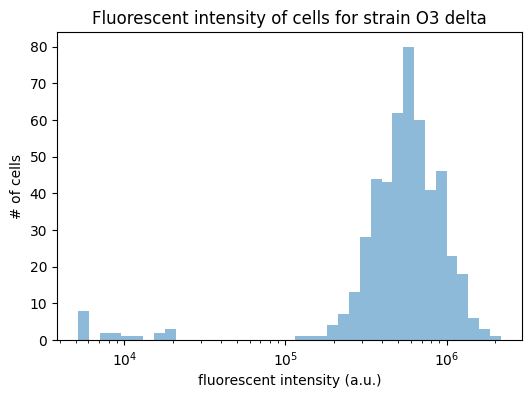

In [ ]:
examples_strain = [('O1', 'auto'),('O2', 'auto'),('O2', 'delta'),('O3', 'delta') ]

#plotted seperately this time to demonstrate that they are gaussian distributions

for i in range(len(examples_strain)):
    fig, ax = plt.subplots(figsize=(6,4))
    ax.set_xscale('log')
    ax.set_xlabel('fluorescent intensity (a.u.)')
    ax.set_ylabel('# of cells')
    strain_int_list = np.asarray(strain_totals(examples_strain[i][0], examples_strain[i][1]))
    num_bins = 40
    lower_bound = np.log10(strain_int_list.min())
    upper_bound = np.log10(strain_int_list.max())
    hist_bins = np.logspace(lower_bound, upper_bound, num_bins)
    # actually make the plot
    ax.hist(strain_int_list, bins=hist_bins,alpha=0.5, label= (examples_strain[i][0] + "" + examples_strain[i][1]))
    plt.title("Fluorescent intensity of cells for strain " + examples_strain[i][0] + " " + examples_strain[i][1] )

## Question 1f

In [ ]:
ops = ['O1', 'O2', 'O3']
rep_names = ['R22', 'R60', 'R124', 'R260']
rep_nums= [22, 60, 124, 260]

def calc_fold_change(ops, rep_names, rep_nums):
  mean_intensity = np.zeros((len(ops), len(rep_names)))
  fold_change = np.zeros((len(ops), len(rep_names)))

  for i in range(len(ops)):
    op=ops[i];
    auto_inten = np.mean(strain_totals(op, 'auto'))
    delta_intensity = np.mean(strain_totals(op, 'delta'))
    for j in range(len(rep_names)):
      repressor = rep_names[j];
      mean_intensity[i,j]=np.mean(strain_totals(op, repressor))
      fold_change[i,j]=(mean_intensity[i,j] - auto_inten)/(delta_intensity - auto_inten)
  return fold_change


fold_change_values = calc_fold_change(ops, rep_names, rep_nums)
print("2d array of the fold change values")
print(calc_fold_change(ops, rep_names, rep_nums))

2d array of the fold change values
[[0.02056048 0.01893591 0.00956368 0.00543919]
 [0.14333886 0.04184557 0.01433534 0.0094888 ]
 [0.89636117 0.7426897  0.97316665 0.73530407]]


## Question 1g

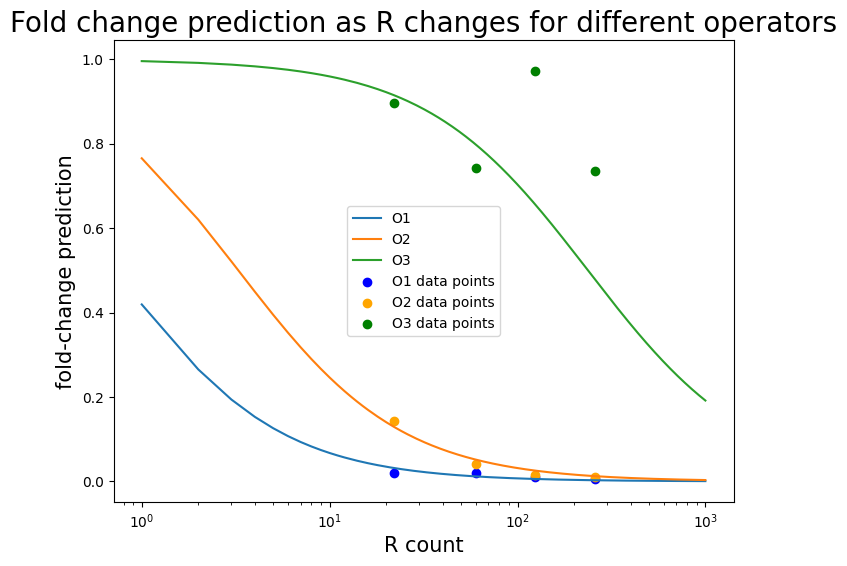

In [ ]:
O1_E_r = -15.667
O2_E_r = -14.158
O3_E_r = -9.873

R = np.linspace(1, 1000, 1000)




rep_nums= [22, 60, 124, 260]
#uses functions defined in code above
fig, ax = plt.subplots(figsize=(8, 6))
plot_operator(O1_E_r)
plot_operator(O2_E_r)
plot_operator(O3_E_r)
colors = ['blue' , 'orange', 'green']
for i in range(len(fold_change_values)):
  plt.scatter(rep_nums, fold_change_values[i], color= colors[i])
plt.xscale('log')
plt.title("Fold change prediction as R changes for different operators", size = 20);
plt.xlabel('R count', size = 15);
plt.ylabel('fold-change prediction', size = 15);
ax.legend(["O1","O2", "O3", "O1 data points","O2 data points", "O3 data points"]);
plt.show()

A reason for the outliers may be that the image processing does not correctly calculate the number of cells because cells could be touching or very close together, resulting in two cells being counted as one. Another reason could be external factors which may cause differences in the amount of fluorescence in a cell.

## Question 1h

In [ ]:
lacZ = pd.read_csv('/content/drive/MyDrive/lacZ_titration_data.csv', header = 8)
lacZ

,repressor,fold_change,operator
0,22.42,0.798500,O3
1,59.34,0.652400,O3
2,124.00,0.621000,O3
3,255.30,0.477300,O3
4,22.42,0.175600,O2
5,59.34,0.045190,O2
6,124.00,0.021510,O2
7,255.30,0.012410,O2
8,22.42,0.038860,O1
9,59.34,0.008902,O1


In [ ]:
Nns = 4.6 * 10**6
R = 1
fc = 1
fold_change = 1


def new_fold_change(R, E_r):
  return (1 / (1 + (R / N_ns) * math.exp(-1 * E_r)))

def log_fold_change(R, E_r):
    return np.log(new_fold_change(R, E_r))


def fit_epsilon(operator):
  r_vals = lacZ[lacZ['operator'] == operator]['repressor']
  fc_vals_lacZ = lacZ[lacZ['operator'] == operator]['fold_change']
  popt1, pcov1 = scipy.optimize.curve_fit(log_fold_change, r_vals, np.log(fc_vals_lacZ))
  return popt1[0];

#store the values for later
microscopy_values = [fit_epsilon('O1'), fit_epsilon('O2'), fit_epsilon('O3')]

print("Using lacZ fold change:")
print('O1: delta E_r = ' + str(microscopy_values[0]))
print('O2: delta E_r = ' + str(microscopy_values[1]))
print('O3: delta E_r = ' + str(microscopy_values[2]))

print("single point values from earlier " + str(single_point_values));

Using lacZ fold change:
O1: delta E_r = -15.776722043610896
O2: delta E_r = -14.170113368518724
O3: delta E_r = -10.046001265092682
single point values from earlier [-15.667, -14.158, -9.873]


They are pretty close to the single point values, although the single point value seem to be a little lower than the least squares one.

## Question 1i

In [ ]:
#now find a binding energy, using the inverse of last question, now with microscopy fold change data

lacZ_values = []
print("Using microscopy fold change:")
popt1, pcov1 = scipy.optimize.curve_fit(log_fold_change, rep_nums, np.log(fold_change_values[0]))
print('O1: delta E_r = ' + str(popt1[0]))
lacZ_values.append(popt1[0])

popt1, pcov1 = scipy.optimize.curve_fit(log_fold_change, rep_nums, np.log(fold_change_values[1]))
print('O2: delta E_r = ' + str(popt1[0]))
lacZ_values.append(popt1[0])

popt1, pcov1 = scipy.optimize.curve_fit(log_fold_change, rep_nums, np.log(fold_change_values[2]))
print('O3: delta E_r = ' + str(popt1[0]))
lacZ_values.append(popt1[0])


Using microscopy fold change:
O1: delta E_r = -15.354179295753148
O2: delta E_r = -14.417133188430752
O3: delta E_r = -8.757248237116844


The inferred binding energies are slightly different from the single points values and the regression in 1h, ranging from around a 0.2 different to a 1.3 difference. The discrepancy is most probably because a difference in the number of repressors used in each of the techniques. Part h uses very specific repressor values (printed above).

## Question 1j

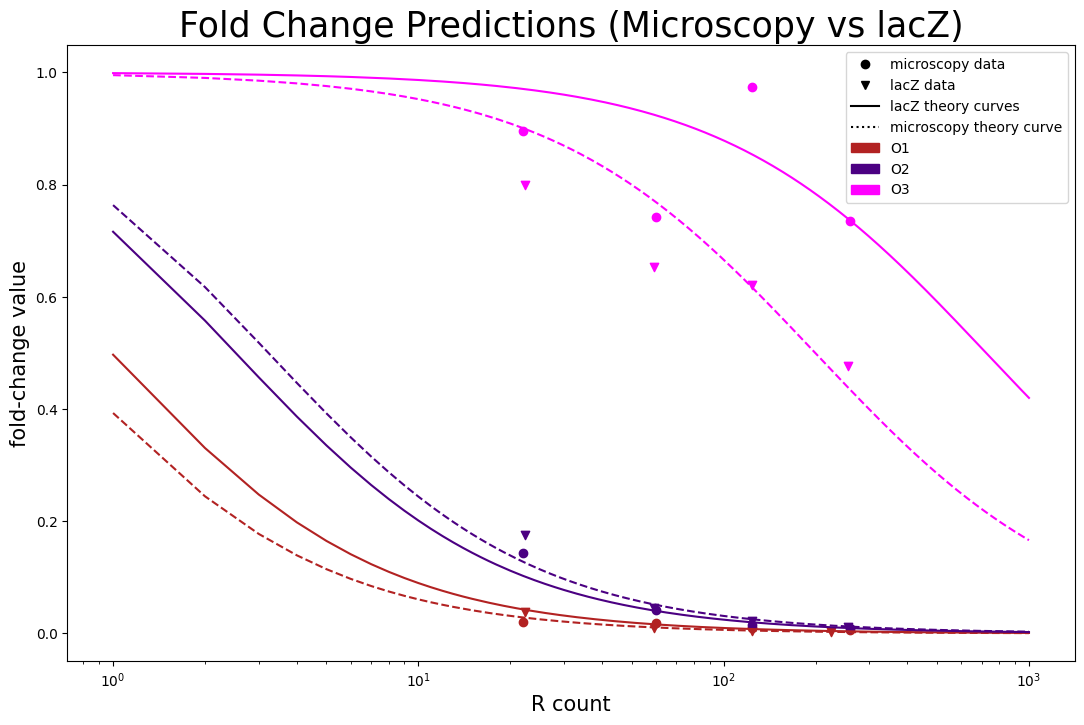

In [ ]:
fig, ax = plt.subplots(figsize=(13,8))

colors = ['firebrick' , 'indigo', 'magenta']
#plot lacZ data points
def plot_lacZ_data(operator, index):
  r_vals = lacZ[lacZ['operator'] == operator]['repressor']
  fc_vals_lacZ = lacZ[lacZ['operator'] == operator]['fold_change']
  plt.scatter(r_vals, fc_vals_lacZ, color = colors[index], marker = 'v')

plot_lacZ_data("O1", 0)
plot_lacZ_data("O2", 1)
plot_lacZ_data("O3", 2)

# plots the miscroscopy data points
for i in range(len(fold_change_values)):
  plt.scatter(rep_nums, fold_change_values[i], color= colors[i])


# now microscopy curve
R = np.linspace(1, 1000, 1000)
plt.plot(R, new_fold_change(R , microscopy_values[0]), color = colors[0], linestyle = 'dashed');
plt.plot(R, new_fold_change(R , microscopy_values[1]), color = colors[1], linestyle = 'dashed');
plt.plot(R, new_fold_change(R , microscopy_values[2]), color = colors[2], linestyle = 'dashed');

# now to plot lacZ expected curve
plt.plot(R, new_fold_change(R , lacZ_values[0]), color = colors[0]);
plt.plot(R, new_fold_change(R , lacZ_values[1]), color = colors[1]);
plt.plot(R, new_fold_change(R , lacZ_values[2]), color = colors[2]);


# set up plot to look nice
plt.xscale('log')
plt.title('Fold Change Predictions (Microscopy vs lacZ)', fontsize= 25)
plt.xlabel('R count', fontsize= 15)
plt.ylabel('fold-change value',fontsize= 15)

#legend (uses import to group data together)
ax.legend(handles=[mlines.Line2D([], [], color = 'black', ls = "", marker = 'o', label = 'microscopy data' ),
                   mlines.Line2D([], [], color = 'black', ls = "", marker = 'v', label = 'lacZ data' ),
                   mlines.Line2D([], [], linestyle = 'solid',  label = 'lacZ theory curves', color = 'black'),
                   mlines.Line2D([], [],  linestyle = 'dotted', label = 'microscopy theory curve', color = 'black'),
                   mpatches.Patch(color = colors[0], label = 'O1'),
                   mpatches.Patch(color = colors[1], label = 'O2'),
                   mpatches.Patch(color = colors[2], label = 'O3')]);
plt.show()

The theories produce slightly different results, notably, the lacZ theory curve produced larger fold-change values for the O1 and O3 strains, but lower values for O2. Despite the difference between the theories, I would say that the difference is due to fault in the measurements, as if the one of the theories were faulted they would consistently produce higher or lower fold-change values than the other theory. This is not the case, so we can conclude that the slight disagreement is due to fault of measurement. Also, the slope of the curves appears to be similar between both theories.

---

### Submission instructions

When you're finished, recall the steps for submitting Colab notebooks:

1. Run all the cells from top-to-bottom, in order (`Runtime` > `Run all`).
2. Once the entire notebook has completed running and the output of all cells is visible, save it (`File` > `Save`).
3. Download the notebook in `.ipynb` format (`File` > `Download` > `Download .ipynb`).
4. Rename the file according to the usual convention (`lastname_firstname_hw#.ipynb`), if you haven't already.
5. Upload the file to Canvas.
